# Heuristic plot of Approximation Ratio vs number of nodes

In [112]:
import qtensor
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams.update({'font.size': 16})

In [56]:
ls -l ../data

total 8
-rw-r--r-- 1 danlkv jlse 1024 May 25 18:09 QAOA_cost_vs_N.npy
-rw-r--r-- 1 danlkv jlse  408 May 25 18:09 gurobi_cost_vs_N.npy


In [45]:
SEEDS = [10, 11, 12, 13, 14]
SIZES = [2**x for x in range(3, 10)]

In [63]:
graphs = np.array([
    [nx.random_regular_graph(3, N, seed=seed) for seed in SEEDS]
    for N in SIZES
], dtype=object)

## Read gurobi solution data

In [16]:
gurobi_sol = np.load('../data/gurobi_cost_vs_N.npy')
gw_sol = np.load('../data/GW_cost_vs_N.npy')
qaoa_sol = np.load('../data/QAOA_cost_vs_N.npy')[0]
gurobi_sol.shape, gw_sol.shape, qaoa_sol.shape

((7, 5), (7, 5), (4, 7, 4))

## Plot data
### Helper functions

In [113]:
def get_colors(num=2, offset=0.25, cmap=mpl.cm.gnuplot2):
    """
    returns:
        Array of len ``num``.
    """
    
    return np.array([cmap(x) for x in np.linspace(offset, 1-offset, num)])

c_prim, c_sec = get_colors(offset=0.25)

In [251]:
from mpl_toolkits.axes_grid1 import Divider, Size

def add_sized_axis(fig, axsize, right=False):
    # The first items are for padding and the second items are for the axes.
    # sizes are in inch.
    h = [Size.Fixed(1.0), Size.Fixed(axsize[0]), Size.Fixed(.5)]
    if right:
        h = list(reversed(h))
    v = [Size.Fixed(0.7), Size.Fixed(axsize[1])]

    divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
    # The width and height of the rectangle are ignored.

    ax = fig.add_axes(divider.get_position(),
                      axes_locator=divider.new_locator(nx=1, ny=1))

In [252]:
def plot_with_range(x, data, color,
                    label='Average',
                    shade_label='',
                    alpha=0.15
                   ):
    mi = data.min(-1)
    av = np.average(data, -1)
    ma = data.max(-1)

    plt.plot(x, av,'o-', label=label, color=color)
    #plt.plot(np.arange(1,12),maxAR,'.-',label='Max', color=c_prim)
    #plt.plot(np.arange(1,12),minAR,'.-', label='Minimum', color=c_prim)
    plt.fill_between(x, mi, ma, color=color, alpha=alpha, label=shade_label)
   

### Plotting functions

In [253]:
def plot_pr_p(x, data, c_prim, c_sec, alpha=0.15, axsize=(6, 6/1.618)):
    margin = (0.2, 0.2)
    fig = plt.figure(figsize=(axsize[0]+1.5, axsize[1]+.8))
    add_sized_axis(fig, axsize)
    #plt.subplots_adjust(left=0.15,right=0.85)
    colors_p = iter(get_colors(num=len(data), offset=0.2))
    for i, data_p in enumerate(data):
        p = i+1
        plot_with_range(x, data_p,
                        color=next(colors_p),
                        label=f'p={p}'
                       )

    plt.hlines(1, min(x), max(x), color=c_sec, linestyle='--')

    ax = plt.gca()
    plt.ylim(0.67, 1.01)
    plt.xlabel('p')
    plt.ylabel('Performance ratio')
    plt.legend(title='Averages', loc='lower right', ncol=2)
    plt.grid(alpha=0.3)
    print(plt.gca().dataLim.bounds)
    return fig


(8.0, 0.747824264310768, 504.0, 0.252175735689232)


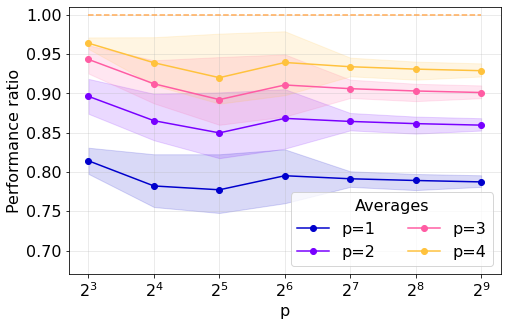

In [254]:
plot_pr_p(SIZES, qaoa_sol/gw_sol[:,:4], c_prim, c_sec)
plt.xscale('log', base=2)

plt.savefig('./pdf/pr_vs_N.pdf')

In [255]:
def plot_ar_p(x, data, c_prim, c_sec,
              alpha=0.15, axsize=(6, 6/1.618),
              guarantees=True
             ):
    margin = (0.2, 0.2)
    fig = plt.figure(figsize=(axsize[0]+1.5, axsize[1]+.8))
    add_sized_axis(fig, axsize, right=True)
    #plt.subplots_adjust(left=0.15,right=0.85)
    colors_p = iter(get_colors(num=len(data), offset=0.2))
    for i, data_p in enumerate(data):
        p = i+1
        plot_with_range(x, data_p,
                        color=next(colors_p),
                        label=f'p={p}'
                       )

    ax = plt.gca()
    plt.xlabel('N')
    plt.ylabel('Approximation ratio')
    plt.legend(title='Averages', loc='upper right', ncol=2)
    
    plt.grid(alpha=0.3)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    plt.ylim(0.68, 1.05)
    
    if guarantees:
        colors_p = iter(get_colors(num=len(data), offset=0.2))
        guarantees = [qtensor.tools.BETHE_QAOA_VALUES[str(p)]['val'] for p in range(1, 5)]
        rightpos = max(x)*1.5
        for g_p in guarantees:
            plt.hlines(g_p, max(x)/1.2, rightpos,
                       color=next(colors_p),
                       linestyle='--', linewidth=2)
        plt.xlim(min(x)/1.2, rightpos)
        guarantee_ticks = [np.round(x, 3) for x in guarantees]
        ticks = guarantees + [0.85, 0.90, 0.95, 1.00]
        plt.yticks(ticks=ticks, labels=[np.round(x, 2) for x in ticks])

    return fig

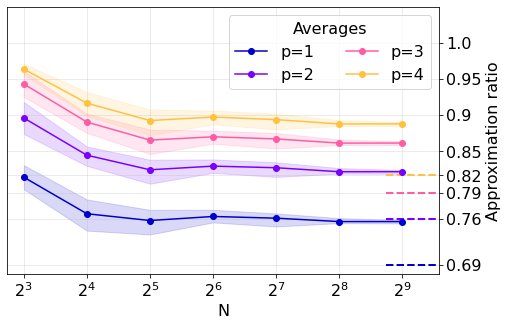

In [256]:
plot_ar_p(SIZES, qaoa_sol/gurobi_sol[:,:4], c_prim, c_sec)
plt.xscale('log', base=2)
plt.savefig('./pdf/ar_vs_N.pdf')

---
## _Post Scriptum_

### derivative of AR vs N

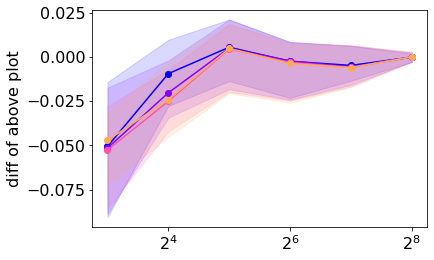

In [238]:
rt = qaoa_sol/gurobi_sol[:,:4]
tt = rt[:, 1:] - rt[:, :-1]
colors = iter(get_colors(len(tt)))
for x in tt:
    plot_with_range(SIZES[:-1], x, color=next(colors))
plt.ylabel('diff of above plot')
plt.xscale('log', base=2)

### double-check the data


In [81]:
# this should not raise any errors
for ni, si in [(3, 4), (1, 2), (5, 2)]:
    cost, sol = qtensor.tools.maxcut.gurobi_maxcut(graphs[ni, si])
    assert cost == gurobi_sol[ni, si]

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 56 physical cores, 112 logical processors, using up to 32 threads
Optimize a model with 0 rows, 64 columns and 0 nonzeros
Model fingerprint: 0xb29fb9dd
Model has 96 quadratic objective terms
Variable types: 0 continuous, 64 integer (64 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve time: 0.00s
Presolved: 96 rows, 160 columns, 288 nonzeros
Variable types: 0 continuous, 160 integer (160 binary)

Root relaxation: objective -9.600000e+01, 66 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   96.00000    0   64   -0.00000   96.00000      -     -    0s
H    0     0            

(8.0, 0.805265436256967, 504.0, 0.194734563743033)


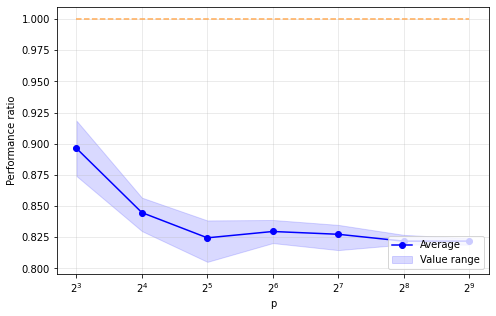

In [42]:
plt.xscale('log', base=2)